In [ ]:
#To, do tommorrow. make nice graphs and presentation. 

Device =  cuda:0
DEBUGGING: torch.cuda.is_available() =  True
Number of training graphs: 14850
Number of validation graphs: 1856
Number of test graphs: 1857


/hpc/home/kam264/.local/lib/python3.8/site-packages/torch_geometric/data/dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


Epoch  0  Train mse:  0.06019200597146545
Epoch  0  Validation mse:  0.05939628890362279
Epoch  3  Train mse:  0.05906647356270941
Epoch  3  Validation mse:  0.05827454593161057


Text(0, 0.5, 'MSE')

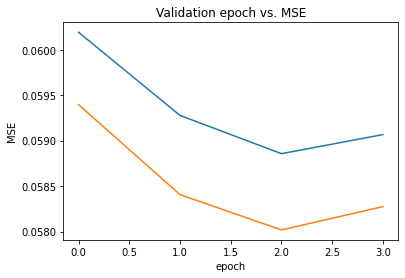

In [1]:
import pandas as pd
import os
import numpy as np
import numpy.ma as ma  
import awkward as ak 
from tqdm import tqdm 
import torch 
import torch_geometric as tg  
import torch_geometric 
from torch_geometric.data import Data 
#import torch 
from torch_geometric.data import InMemoryDataset, download_url  
import torch_geometric.transforms as T 

#NOTE: NEW 2/20/23      
from typing import List, Union    

from torch_geometric.data import Data, HeteroData 
from torch_geometric.data.datapipes import functional_transform
from torch_geometric.transforms import BaseTransform      
torch.cuda.empty_cache()  

#root = '/hpc/group/vossenlab/kam264/mom_magnitude_pi_x_cx_recmomfull_20000' not horrible, ksate around .2
#root = '/hpc/group/vossenlab/kam264/mom_magnitude_pi_x_cx_recfull_vertmom_20000' #much better, bad peak and dip though, so if can fix that, p value
#.09, KstestResult(statistic=0.09777468706536856, pvalue=2.779826736292836e-60)
#root = '/hpc/group/vossenlab/kam264/mom_magnitude_pi_onlymomentum_rec_20000' shit
#root = '/hpc/group/vossenlab/kam264/mom_magnitude_pi_mommnetumvertx_rec_20000'
#root = '/hpc/group/vossenlab/kam264/mom_magnitude_pi_all_rec_20000'#not bad, need to do rec stuff though 
#root = '/hpc/group/vossenlab/kam264/mom_magnitude_pi_all_protmom_20000' #same as above, but got it printed. but rec is jsut z part. 
#root = '/hpc/group/vossenlab/kam264/stupid_idea' #same as above, but got it printed. but rec is jsut z part. 
#root = '/hpc/group/vossenlab/kam264/pi_phi_polar'#, mse seems to be better
#root = '/hpc/group/vossenlab/kam264/pi_theta_polar' #goodd
#root = '/hpc/group/vossenlab/kam264/pi_r_polar' #see slides, week 6 update 
#root = '/hpc/group/vossenlab/kam264/everythingppi_pionvvv' #not what i ment, actully decent at pion zmomnetum.
#root = '/hpc/group/vossenlab/kam264/everythingpi_randomgaus' #bad
#root = '/hpc/group/vossenlab/kam264/everythingpi_rrrrandomgausss'
#root = '/hpc/group/vossenlab/kam264/testt_20000' 
#root = '/hpc/group/vossenlab/kam264/testmrone_20000' 
#root = '/hpc/group/vossenlab/kam264/testrkin_20000' #really bad
#root = '/hpc/group/vossenlab/kam264/test_momcut_20000' 
#root = '/hpc/group/vossenlab/kam264/test_100'
#root = '/hpc/group/vossenlab/kam264/ttest_wmom_eL'
root = '/hpc/group/vossenlab/kam264/ttest_L_imass'
root = '/hpc/group/vossenlab/kam264/test_L_imassss' 
root = '/hpc/group/vossenlab/kam264/test_LL_imass' 
root = '/hpc/group/vossenlab/kam264/L_imass4' 
root = '/hpc/group/vossenlab/kam264/L_imass5' 
root = '/hpc/group/vossenlab/kam264/L_imass6' #like 25% lambda events
root = '/hpc/group/vossenlab/kam264/L_imass8' #same as above, but different set, so can use for testing. 
#root = '/hpc/group/vossenlab/kam264/L_imass3'


class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])
        # For PyG<2.4:
        # self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        # Read data into huge `Data` list.
        data_list = None

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])
        # For PyG<2.4:
        # torch.save(self.collate(data_list), self.processed_paths[0])

# Create PyG Dataset
#root = '/hpc/group/vossenlab/kam264/pyg_test_rec_traj_dataset_5_28_24/' # 3_14_24 #OLD
dataset = MyOwnDataset(
            root,
            transform=None, #T.Compose([T.ToUndirected(),T.KNNGraph(k=6)]),
            pre_transform=None,
            pre_filter=None
        ) 
dataset
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.norm import GraphNorm, BatchNorm 

batch_size = 64
LR =1e-3

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels): 
        super(GCN, self).__init__()
#         torch.manual_seed(12345)
        self.conv1 = GCNConv(in_channels, hidden_channels)#.jittable() #NOTE: NEEDED FOR DEPLOYMENT IN CMAKE
        self.conv2 = GCNConv(hidden_channels, hidden_channels)#.jittable()
        #self.block2 = nn.DataParallel(self.block2)
        #self.conv2 = torch.nn.DataParallel(self.conv2) #this was trying the parallization thing. 
        self.conv3 = GCNConv(hidden_channels, hidden_channels)#.jittable()
        #self.conv3 = torch.nn.DataParallel(self.conv3)
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, out_channels)
        self.bn1 = torch_geometric.nn.norm.GraphNorm(hidden_channels)
        self.bn2 = torch_geometric.nn.norm.GraphNorm(hidden_channels)
        self.bn3 = torch_geometric.nn.norm.GraphNorm(hidden_channels)

    def forward(self, x, edge_index, batch): 
        # 1. Obtain node embeddings 
       # x = self.conv1(x, edge_index) #input layer
      #  x = self.bn1(x) #normalize it
     #   x = x.relu() #activation
#         x = torch.nn.function.elu(x)
#        x = self.conv2(x, edge_index)
#        x = self.bn2(x)
#        x = x.relu() 
#         print("x.relu() = ",x)
#        x = self.conv3(x, edge_index)
#        x = self.bn3(x)
#         # 2. Readout layer
 #       x = global_mean_pool(x, batch) #what is this for.           # [batch_size, hidden_channels]
  #      x = F.dropout(x, p=0.5, training=self.training) #for overfitting
   #     x = self.lin3(x)
        
        x = self.conv1(x, edge_index) #input layer                             
                                                      
        x = self.bn1(x) #normalize it                                          

        x = x.relu() #activation                                               
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = x.relu()
#         print("x.relu() = ",x)  
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
#         # 2. Readout layer                                                   
        x = global_mean_pool(x, batch)
        # 3. Apply a final classifier                                          
        x = F.dropout(x, p=0.5, training=self.training) #for overfittin        
        x = self.lin3(x)
 
        return x

model = GCN(dataset.num_node_features,64,2)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
#devicee = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu') 
print("Device = ",device)
model = model.to(device)
print("DEBUGGING: torch.cuda.is_available() = ",torch.cuda.is_available())

from torch.utils.data import random_split #TODO: SEE IF YOU CAN USE THIS
# torch.manual_seed(12345)
# print('DEBUGGING: BEFORE: dataset.y.shape = ',dataset.y.shape)
dataset = dataset.shuffle() #shuffle (randmoize placement of it) not sure if this is needed. 
#print('DEBUGGING: AFTER:  dataset.y.shape = ',dataset.y.shape)

#print(len(dataset)) 

fracs = [0.8, 0.1, 0.1] #percent of dataset used for training testing and validatoin 80%,10%,10% #NOTE: SHOULD CHECK np.sum(fracs) == 1 and len(fracs)==3
fracs = [torch.sum(torch.tensor(fracs[:idx])) for idx in range(1,len(fracs)+1)] #get the indexes for training ... parts to use. 
#print(fracs)
split1, split2 = [int(len(dataset)*frac) for frac in fracs[:-1]] 
train_dataset = dataset[:split1]
val_dataset = dataset[split1:split2]
test_dataset = dataset[split2:] 

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}') 

from torch_geometric.loader import DataLoader 
#from torch.utils.data import WeightedRandomSampler


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)#, drop_last=True)
val_loader = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

model = GCN(dataset.num_node_features, dataset.num_classes, 1).to(device) #initiate the model, #2 is the number of outputs here is 2 as pion_z, proton_z 

optimizer = torch.optim.Adam(model.parameters(), lr= LR) #get the optimizer

data_labels = train_dataset.y 
#weight_signal = counts[1]/counts[0]#DEBUGGING MULTIPLY BY 2 ...
#print("weight_signal = ",weight_signal) 
# weight = torch.FloatTensor([weight_signal, 1.0]).to(device) #NOTE: That labels are [sg?,bg?] so label 0 in this case is sg and label 1 is bg.


#losss = torch.nn.MSELoss(reduction = 'mean').to(device)
#losss = torch.sqrt(losss)

#RMSE loss. 
def RMSELoss(out,y):
    return torch.sqrt(torch.mean((out-y)**2))
losss = RMSELoss 

#custom losss
def pion_los(out,y):
    mse_pi = 0
    for j in range(len(out)):
            #x_pi = out[j][0]; x_p =out[j][1]                                                                                                                                                                                                 

        mse_pi += (out[j][0]-y[j][0].item() )**2
    return torch.sqrt(mse_pi/len(out))

#losss = pion_los



def train():
    model.train() #initailize the model                                                                                                                                                                                                       
    #for i, data in tqdm(enumerate(train_loader)): #perhaps tqdm(enumerate(train_loader)), i is index, data jsut moves through all the dtaa in trainingg                                                                                      
    for i,data in enumerate(train_loader):
        data = data.to(device) #switch to GPU                                                                                                                                                                                                 
        optimizer.zero_grad() #                                                                                                                                                                                                               
        out = model(data.x, data.edge_index, data.batch).to(device)  # Perform a single forward pass                                                                                                                                          
        yy = []
        for j in range(0,len(out)):
            yy+= [[data.y[j].item()]]

        yy = torch.tensor(yy).to(device)
        #print(out)
        #print(yy)
        loss = losss(out, yy).to(device) #compute the loss  
        #print(loss)
        loss.backward() #get the gradients.                                                                                                                                                                                                   
        optimizer.step() #take a step.                                                                                                                                                                                                        

#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import roc_auc_score 

def test(loader):
    length = len(loader.dataset)
    model.eval() #evaluate teh model.                                                                                                                                                                                                         

    #mse_tot = []                                                                                                                                                                                                                             
    mse_total = 0
    mse_pi = 0
    mse_p = 0
    #r                                                                                                                                                                                                                                        
    #for data in tqdm(loader):  # Iterate in batches over the training/test dataset.                                                                                                                                                          
    for data in loader:
        data = data.to(device) #put to GPU                                                                                                                                                                                                    
        out = model(data.x, data.edge_index, data.batch).to(device) #evalueate                                                                                                                                                                
        #this and the for loop is converting data.y to a tensor in the same shape as out rows and 2 columns first is y_pion second is y_proton                                                                                                
        yy = []
        for j in range(0,len(out)):
            yy+= [[data.y[j].item()]]
        yy = torch.tensor(yy).to(device) 
        loss = losss(out, yy).cpu() #getting teh loss function                                                                                                                                                                                
        mse_total+=loss.item() #getting the mse (total)                                                                                                                                                                                       
        #for j in range(len(out)):
            #x_pi = out[j][0]; x_p =out[j][1]                                                                                                                                                                                                 

         #   mse_pi += (out[j][0].item()-yy[j][0].item() )**2 
          #  mse_p +=(out[j][1].item()-yy[j][1].item())**2

        #)                                                                                                                                                                                                                                    
    return mse_total/length #, np.sqrt(mse_total/length), mse_pi/length, np.sqrt(mse_pi/length), mse_p/length, np.sqrt(mse_p/length) 

        
def print_out():
    model.eval() #initailize the model                                                                                                                                                                                                        
    #for i, data in tqdm(enumerate(train_loader)): #perhaps tqdm(enumerate(train_loader)), i is index, data jsut moves through all the dtaa in trainingg                                                                                      
    outt= []
    for i,data in enumerate(test_loader):
        data = data.to(device) #switch to GPU                                                                                                                                                                                                 
        optimizer.zero_grad() #                                                                                                                                                                                                               
        out = model(data.x, data.edge_index, data.batch).to(device)  # Perform a single forward pass                                                                                                                                          
        out = out.cpu()
        #yy = []                                                                                                                                                                                                                              
        #for j in range(0,2*len(out),2):                                                                                                                                                                                                      
        #    fuckk = data.y[j]; fuckj = data.y[j+1]                                                                                                                                                                                           
        #    yy +=[[fuckk.item(),fuckj.item()]]                                                                                                                                                                                               
        #yy = torch.tensor(yy).to(device)                                                                                                                                                                                                     
        #loss = losss(out, yy).cpu() #compute the loss                                                                                                                                                                                        
        outt+=[[out.detach().numpy()]]
    return outt

def print_outb():
    model.eval() #initailize the model                                                                                                                                                                                                        
    #for i, data in tqdm(enumerate(train_loader)): #perhaps tqdm(enumerate(train_loader)), i is index, data jsut moves through all the dtaa in trainingg      
    root = '/hpc/group/vossenlab/kam264/L_imass9'  
    dataset = MyOwnDataset(
            root,
            transform=None, #T.Compose([T.ToUndirected(),T.KNNGraph(k=6)]),
            pre_transform=None,
            pre_filter=None
        )
    #print(dataset)
    dataset = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    outt= [] 
    for i,data in enumerate(dataset):
        data = data.to(device) #switch to GPU                                                                                                                                                                                                 
        optimizer.zero_grad() #                                                                                                                                                                                                               
        out = model(data.x, data.edge_index, data.batch).to(device)  # Perform a single forward pass                                                                                                                                          
        out = out.cpu()
        #yy = []                                                                                                                                                                                                                              
        #for j in range(0,2*len(out),2):                                                                                                                                                                                                      
        #    fuckk = data.y[j]; fuckj = data.y[j+1]                                                                                                                                                                                           
        #    yy +=[[fuckk.item(),fuckj.item()]]                                                                                                                                                                                               
        #yy = torch.tensor(yy).to(device)                                                                                                                                                                                                     
        #loss = losss(out, yy).cpu() #compute the loss     
        neww = []
        for j in range(len(data)):
            neww.append(out[j].item() -data.elc[j][0])
        outt+=[[neww]]
    return outt
nepochs =  4
train_metrics = {'mse':[], "rmse":[], 'mse_pi':[], 'rmse_pi':[], 'mse_p':[], 'rmse_p':[] } 
vall_metrics = {'mse':[], "rmse":[], 'mse_pi':[], 'rmse_pi':[], 'mse_p':[], 'rmse_p':[] }

for epoch in range(nepochs):  
    '''
    if epoch ==(nepochs-1):
        model.eval()
        outt = []
        for i, data in enumerate(train_loader):
            data = data.to(device) 
            out = model(data.x, data.edge_index, data.batch).to(device)
            out = out.cpu()
            outt+=[[out.detach().numpy()]]
        #print(outt)
        #break'''
    #print("BEFORE TRAIN()")                                                                                                                                                                                                                  
    train()
    #print("BEFORE TEST(TRAIN_LOADER)")                                                                                                                                                                                                       
    #train_mse, train_rmse, train_mse_pi, train_rmse_pi, train_mse_p, train_rmse_p = test(train_loader)
    train_mse = test(train_loader)

    train_metrics['mse'].append(train_mse) 
    #train_metrics['rmse'].append(train_rmse)
    #train_metrics['mse_pi'].append(train_mse_pi)
    #train_metrics['rmse_pi'].append(train_rmse_pi)
    #train_metrics['mse_p'].append(train_mse_p)
    #train_metrics['rmse_p'].append(train_rmse_p)

    #print("BEFORE TEST(VAL_LOADER)")                                                                                                                                                                                                         
    #vall_mse, vall_rmse, vall_mse_pi, vall_rmse_pi, vall_mse_p, vall_rmse_p = test(val_loader)
    vall_mse =test(val_loader) 
    #if epoch==0 or val_roc_auc >np.max(val_metrics["roc_auc"]) :                                                                                                                                                                             
    #    model_best_auc = model                                                                                                                                                                                                               
    #    PATH = '/work/clas12/users/mfmce/CLAS12_Lambda_resolution_REU_2023/model_best_auc.pt'                                                                                                                                                
    #    torch.save({                                                                                                                                                                                                                         
    #        'epoch': epoch,                                                                                                                                                                                                                  
    #        'model_state_dict': model.state_dict(),                                                                                                                                                                                          
    #        'optimizer_state_dict': optimizer.state_dict(),                                                                                                                                                                                  
 #             'loss': loss,                                                                                                                                                                                                                  
    #        }, PATH)                                                                                                                                                                                                                         

    vall_metrics['mse'].append(vall_mse)
    #vall_metrics['rmse'].append(vall_rmse)
    #vall_metrics['mse_pi'].append(vall_mse)
    #vall_metrics['rmse_pi'].append(vall_mse)
    #vall_metrics['mse_p'].append(vall_mse)
    #all_metrics['rmse_p'].append(vall_mse)
    if epoch%9==0:
        print("Epoch ",epoch," Train mse: ",train_mse)
        print("Epoch ",epoch," Validation mse: ",vall_mse)
        #print("Epoch ",epoch," Train mse: ",train_mse," Train rmse: ",train_rmse," Train mse pion: ",train_mse_pi,
         #     " Train rmse pion: ",train_rmse_pi, "Train mse proton:",train_mse_p, "Train rmse proton:",train_rmse_p)
        #print("Epoch ",epoch," Validation mse: ",vall_mse," Validation rmse: ",vall_rmse," Validation mse pion: ",vall_mse_pi,
        #      " Validation rmse pion: ",vall_rmse_pi, "Validation mse proton:",vall_mse_p, "Validation rmse proton:", vall_rmse_p)
    if epoch==(nepochs-1):
        a = print_out()
        #b=  print_outb()
        print("Epoch ",epoch," Train mse: ",train_mse)
        print("Epoch ",epoch," Validation mse: ",vall_mse)
        #print("Epoch ",epoch," Train mse: ",train_mse," Train rmse: ",train_rmse," Train mse pion: ",train_mse_pi,
        #      " Train rmse pion: ",train_rmse_pi, "Train mse proton:",train_mse_p, "Train rmse proton:",train_rmse_p)
        #print("Epoch ",epoch," Validation mse: ",vall_mse," Validation rmse: ",vall_rmse," Validation mse pion: ",vall_mse_pi,
        #      " Validation rmse pion: ",vall_rmse_pi, "Validation mse proton:",vall_mse_p, "Validation rmse proton:", vall_rmse_p) 

        #print(a)
        #b = print_outb()
import matplotlib.pyplot as plt 

epochs = [i for i in range(len(train_metrics["mse"]))]   
plt.figure()
plt.title('Training epoch vs. MSE') 
plt.plot(epochs, train_metrics['mse']) 
plt.xlabel('epoch')
plt.ylabel('MSE')


plt.title('Validation epoch vs. MSE')   
plt.plot(epochs, vall_metrics['mse'])    
plt.xlabel('epoch')  
plt.ylabel('MSE')   


Text(0.5, 0, 'Location of Pion vertex (cm)')

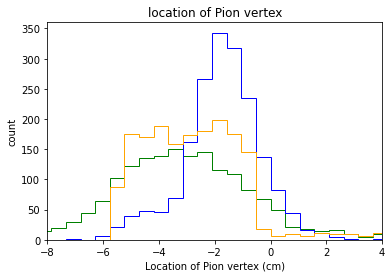

In [2]:
pi_x = []; p_x = [] 
#pi_val = []
for i in range(len(a)):
    for j in range(len(a[i][0])): 
        pi_x.append(a[i][0][j][0].item())
        
        #p_x.append(a[i][0][j][1].item()) 

pi_yy = [] 
#p_yy = []

pi_rec_y = []
#p_rec_y = []
for i, data in enumerate(test_loader):
    data = data#.to(device) #put to GPU
    #break
    for j in range(0,int(len(data.y))): 
        pi_yy.append(data.y[j].item())
 #       p_yy.append(data.y[j+1].item())

        #pi_rec_y.append(data.rec[j].item()) 
       # p_rec_y.append(data.rec[j+1].item())
    for j in range(len(data.rec)):
        #pi_rec_y.append(data.rec[j][0][0])
        pi_rec_y.append(data.rec[j][0])
       # p_rec_y.append(data.rec[j][0][1])


#plott_pi = np.zeros((len(pi_x),4))
#plott_p = np.zeros((len(p_x),2)) 
plott_pi = np.zeros((len(pi_x),3))
for i in range(len(pi_x)):
#for i in range(982):
    plott_pi[i][0] = pi_yy[i]
    plott_pi[i][1] = pi_x[i]
    #plott_pi[i][3] = pi_val[i]
   # plott_pi[i][2] = pi_rec_y[i] 
   # plott_p[i][0] = p_yy[i]
   # plott_p[i][1] = p_x[i]
    #plott_p[i][2]  = p_rec_y[i]  
for i in range(len(pi_rec_y)):  
    plott_pi[i][2] = pi_rec_y[i] 
#plott_pi 
plt.figure
plt.title('Location of Pion Vertex') 
#plt.axvline(x = np.mean(pi_x), color = 'blue')
#plt.axvline(x = np.mean(pi_yy), color = 'orange') 
plt.hist(x = plott_pi, histtype ='step', color = ['orange', 'blue', 'green'], bins = 500 )
#plt.hist(x = plott_pi, histtype ='step',  bins = 100 )
#plt.legend(['Predicted', 'True', 'REC']) 
plt.xlim((-8,4)) 
plt.ylabel('count')
plt.xlabel('Location of Pion vertex (cm)')
#plt.savefig("/hpc/volatile/group/vossenlab/dir_name_2/") 
#plt.savefig("output.pdf")
#plt.hist(x = plott_pi, histtype ='bar', color = ['orange', 'blue'], bins = 30) 


KstestResult(statistic=0.3031771674744211, pvalue=1.0309423379961448e-75)
KstestResult(statistic=0.18686052773290254, pvalue=9.607746619983884e-29)
2.3275288624421173
4.392711121482623
0.19006759792317546
4.122447152786353
-1.1689671739358123
11.615954783265376


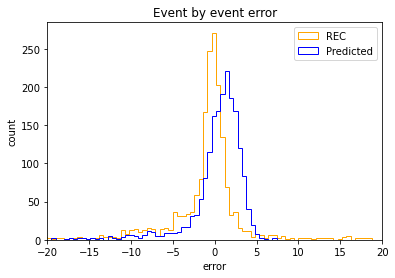

In [3]:
from scipy.stats import kstest   
print(kstest(pi_x, pi_yy)) 
print(kstest(pi_rec_y, pi_yy))   
diff_x = []  
diff_rec = []
for i in range(len(pi_x)):
    diff_x.append(np.sqrt((pi_x[i]-pi_yy[i])**2))
    diff_rec.append(np.sqrt((pi_rec_y[i]-pi_yy[i])**2))
print(np.mean(diff_x)) 
print(np.mean(diff_rec)) 
dif_x = [] 
dif_rec = []
for i in range(len(pi_x)):
    dif_x.append((pi_x[i]-pi_yy[i]))
    dif_rec.append((pi_rec_y[i]-pi_yy[i]))

plottt = np.zeros((len(dif_x), 2)) 
for i in range(len(dif_x)): 
    plottt[i][0] = dif_x[i]
    plottt[i][1] = dif_rec[i]

plt.title('Event by event error')
n, bins = plt.hist(x = plottt, histtype = 'step', color = ['blue', 'orange'], bins = 500)[-1]
plt.legend(['REC', 'Predicted'])
plt.ylabel('count')
plt.xlabel('error')

plt.xlim((-20, 20)) 
from scipy.stats import norm as nm

from statistics import NormalDist
norm = NormalDist.from_samples(dif_x) 
print(norm.mean) 
print(norm.stdev)
xxx = np.linspace(-20, 20, 100)
from statistics import NormalDist 
norm = NormalDist.from_samples(dif_rec) 
print(norm.mean) 
print(norm.stdev) 
xxx = np.linspace(-20, 20, 100)      

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-10.66175938, -10.2885727 ,  -9.91538603,  -9.54219935,
         -9.16901268,  -8.79582601,  -8.42263933,  -8.04945266,
         -7.67626598,  -7.30307931,  -6.92989264,  -6.55670596,
         -6.18351929,  -5.81033261,  -5.43714594,  -5.06395926,
         -4.69077259,  -4.31758592,  -3.94439924,  -3.57121257,
         -3.19802589,  -2.82483922,  -2.45165255,  -2.07846587,
         -1.7052792 ,  -1.33209252,  -0.95890585,  -0.58571918,
         -0.2125325 ,   0.16065417,   0.53384085,   0.90702752,
          1.2802142 ,   1.65340087,   2.02658754,   2.39977422,
          2.77296089,   3.14614757,   3.51933424,   3.89252091,
          4.26570759,   4.63889426,   5.01208094,   5.38526761,
          5.75845428,   6.13164096,   6.5048276

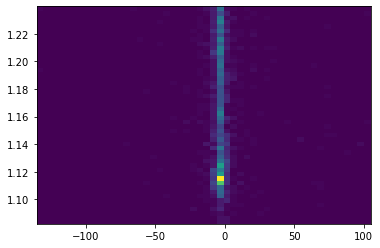

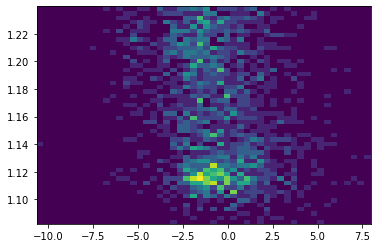

In [4]:
pi_mas = []
#p_rec_y = []
for i, data in enumerate(test_loader):
    data = data#.to(device) #put to GPU
    #break
    for j in range(0,int(len(data.imass))): 
        pi_mas.append(data.imass[j][0]) 

plt.figure()
plt.hist2d(pi_rec_y, pi_mas, bins = 50)

plt.figure()
plt.hist2d(pi_x, pi_mas, bins = 50)

(array([ 6.,  5.,  7., 12., 23., 26., 18., 19., 20., 22., 11., 13., 12.,
         5.,  8.,  5., 12., 15.,  9.,  3., 11.,  8.,  8.,  8., 11.]),
 array([1.0822734 , 1.08853984, 1.09480628, 1.10107272, 1.10733916,
        1.1136056 , 1.11987204, 1.12613848, 1.13240492, 1.13867136,
        1.1449378 , 1.15120424, 1.15747068, 1.16373712, 1.17000356,
        1.17626999, 1.18253643, 1.18880287, 1.19506931, 1.20133575,
        1.20760219, 1.21386863, 1.22013507, 1.22640151, 1.23266795,
        1.23893439]),
 <BarContainer object of 25 artists>)

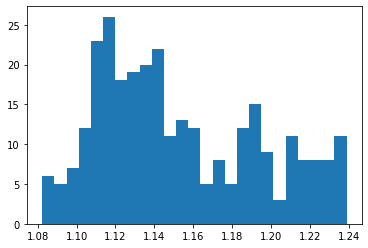

In [5]:
imass = []
for i in range(len(pi_x)):
    if pi_x[i]>1.5:
        imass.append(pi_mas[i])
plt.hist(imass, bins = 25)

(array([ 12.,  19.,  25.,  74., 124., 157., 118.,  88.,  78.,  73.,  67.,
         57.,  77.,  57.,  63.,  57.,  68.,  71.,  66.,  76.,  84.,  74.,
         80.,  84.,  71.]),
 array([1.0822734 , 1.08858179, 1.09489019, 1.10119858, 1.10750697,
        1.11381536, 1.12012375, 1.12643214, 1.13274053, 1.13904892,
        1.14535731, 1.1516657 , 1.15797409, 1.16428248, 1.17059087,
        1.17689926, 1.18320766, 1.18951605, 1.19582444, 1.20213283,
        1.20844122, 1.21474961, 1.221058  , 1.22736639, 1.23367478,
        1.23998317]),
 <BarContainer object of 25 artists>)

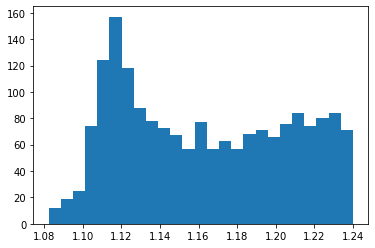

In [6]:
pi_mas = []
#p_rec_y = []
for i, data in enumerate(test_loader):
    data = data#.to(device) #put to GPU
    #break
    for j in range(0,int(len(data.imass))): 
        pi_mas.append(data.imass[j][0])  
plt.hist(pi_mas, bins = 25) 
#plt.xlim((0,3))  

cut  0.0
cut  0.5
cut  1.0
cut  1.5
cut  2.0
cut  2.5
cut  3.0
cut  3.5
cut  4.0
cut  4.5


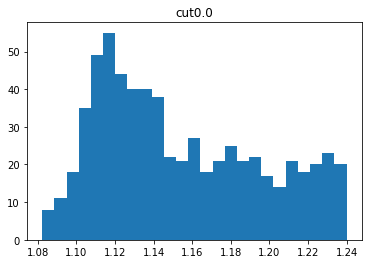

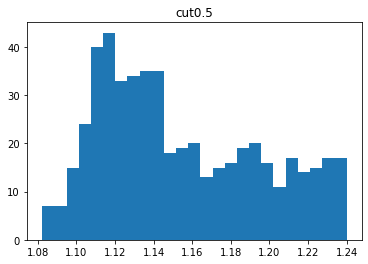

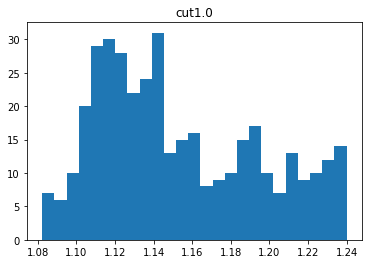

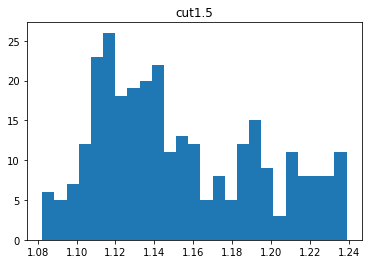

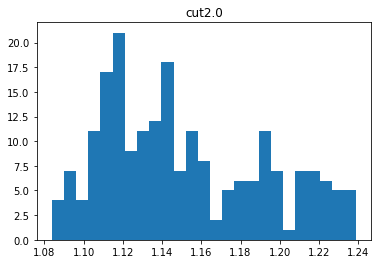

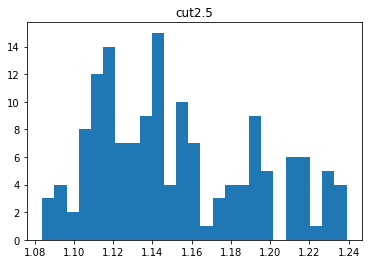

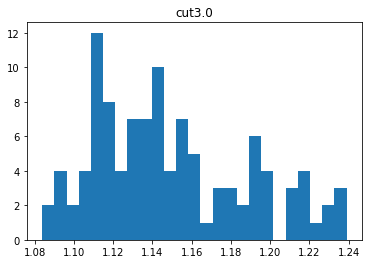

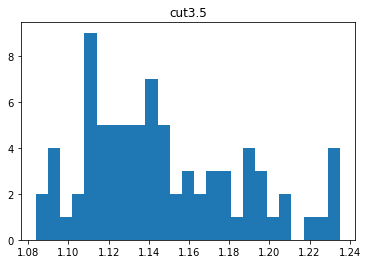

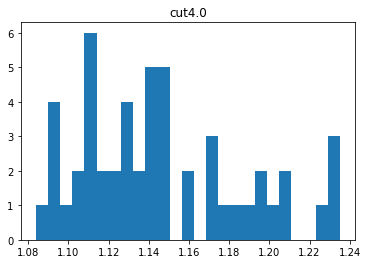

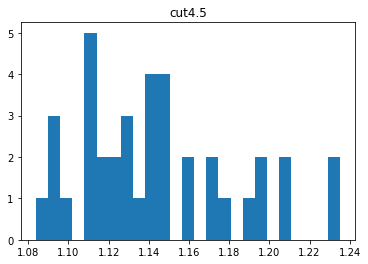

In [7]:
for j in range(0, 10):
    imass = []
    print('cut ',j/2)
    for i in range(len(pi_x)):
        if pi_x[i]>j/2:
            imass.append(pi_mas[i])
    plt.figure()
    plt.title('cut'+str( j/2)) 
    plt.hist(imass, bins = 25)

In [ ]:
#this is for subtracking off the elc cuts. 

Text(0.5, 0, 'Location of Pion vertex (cm)')

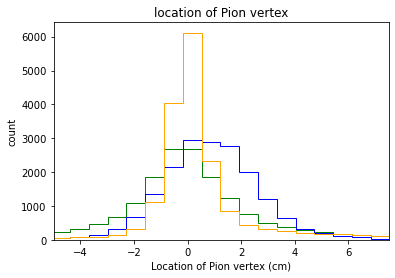

In [2]:
pi_x = []; p_x = [] 
#pi_val = []
for i in range(len(b)):
    for j in range(len(b[i][0])):  
        pi_x.append(b[i][0][j]) 
        
        #p_x.append(a[i][0][j][1].item())  

pi_yy = [] 
#p_yy = [] 

pi_rec_y = []
#p_rec_y = []
for i, data in enumerate(dataset):
    data = data#.to(device) #put to GPU
    #break
    jj= 0
    for j in range(0,int(len(data.y))): 
        pi_yy.append(data.y[j].item() -data.elc[j] ) 
      
    for j in range(len(data.rec)):
        pi_rec_y.append(data.rec[j]-data.elc[j])
       # p_rec_y.append(data.rec[j][0][1])

#plott_pi = np.zeros((len(pi_x),4))
#plott_p = np.zeros((len(p_x),2)) 
plott_pi = np.zeros((len(pi_x),3))
for i in range(len(pi_x)):
#for i in range(982):
    plott_pi[i][0] = pi_yy[i]
    plott_pi[i][1] = pi_x[i]
    #plott_pi[i][3] = pi_val[i]
   # plott_pi[i][2] = pi_rec_y[i] 
   # plott_p[i][0] = p_yy[i]
   # plott_p[i][1] = p_x[i]
    #plott_p[i][2]  = p_rec_y[i] 
for i in range(len(pi_x)): 
    plott_pi[i][2] = pi_rec_y[i] 
#plott_pi 
plt.figure
plt.title('location of Pion vertex') 
#plt.axvline(x = np.mean(pi_x), color = 'blue') 
#plt.axvline(x = np.mean(pi_yy), color = 'orange') 
plt.hist(x = plott_pi, histtype ='step', color = ['orange', 'blue', 'green'], bins = 500 ) 
#plt.hist(x = plott_pi, histtype ='step', bins = 500 )
#plt.legend(['Predicted', 'True', 'REC']) 
#plt.legend(['True', 'Predicted', 'REC']) 
plt.xlim((-5,7.5)) 
plt.ylabel('count') 
plt.xlabel('Location of Pion vertex (cm)')   
#plt.savefig("/hpc/volatile/group/vossenlab/dir_name_2/")
#plt.hist(x = plott_pi, histtype ='bar', color = ['orange', 'blue'], bins = 30)   

In [4]:
data.imass

[1.1152480058191645]

In [ ]:

plt.hist(pi_mas, bins = 15)     

In [4]:
pi_mas = []
#p_rec_y = []
for i, data in enumerate(test_loader):
    data = data#.to(device) #put to GPU 
    #break
    for j in range(0,int(len(data.imass))): 
        pi_mas.append(data.imass[j][0]) 

plt.figure()
#plt.hist2d(pi_rec_y, pi_mas, bins = 100)
#plt.xlim((-5,7.5))

#plt.figure()
#plt.hist2d(pi_x, pi_mas, bins = 100)  
#plt.xlim((-5,10))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

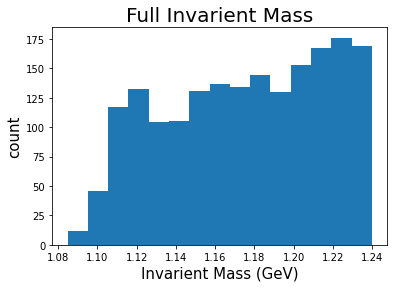

In [5]:
plt.hist(pi_mas, bins = 15) 
plt.title('Full Invarient Mass', fontsize = 20)
plt.xlabel('Invarient Mass (GeV)', fontsize = 15)
plt.ylabel('count', fontsize = 15)
plt.yticks(fontsize=10)
plt.yticks(fontsize=10)   

cut  0.0
cut  0.5
cut  1.0
cut  1.5
cut  2.0
cut  2.5
cut  3.0
cut  3.5
cut  4.0
cut  4.5
cut  5.0
cut  5.5
cut  6.0
cut  6.5
cut  7.0
cut  7.5
cut  8.0
cut  8.5
cut  9.0
cut  9.5


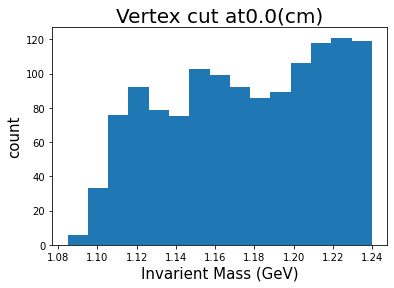

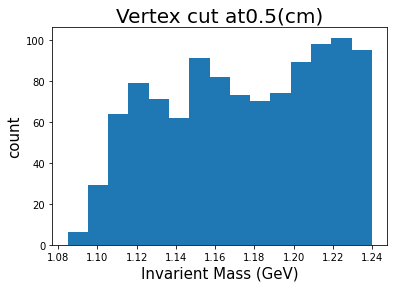

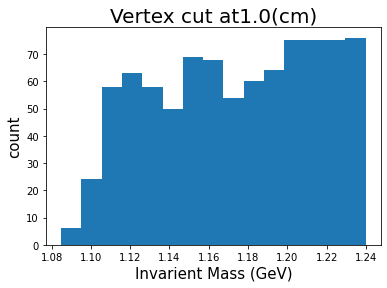

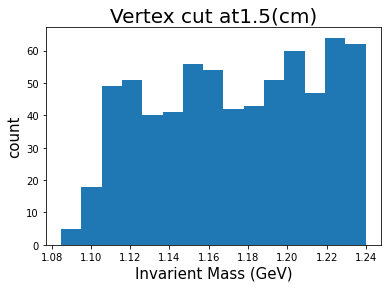

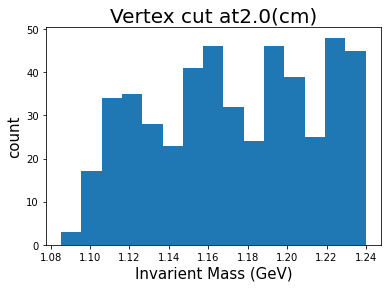

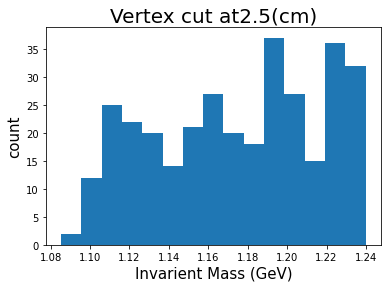

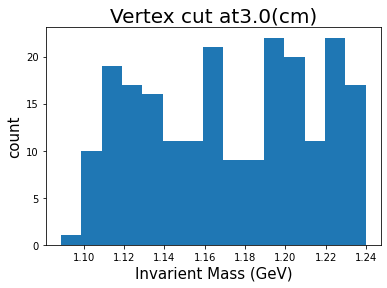

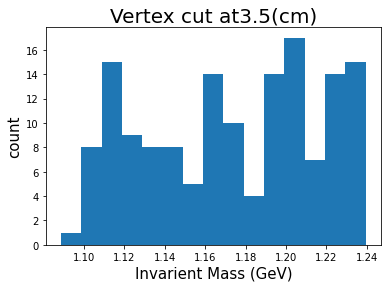

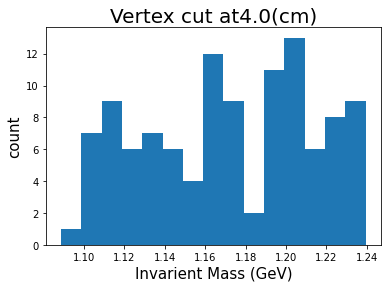

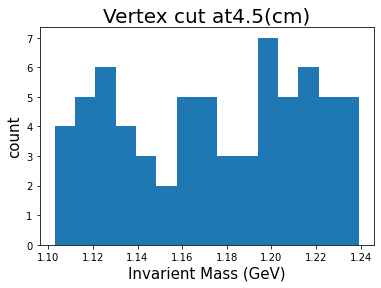

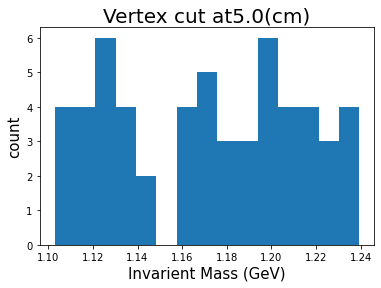

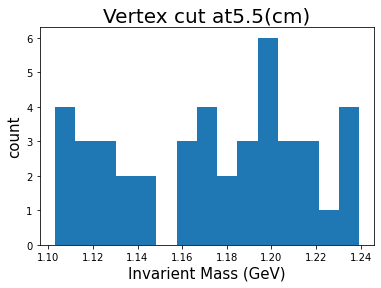

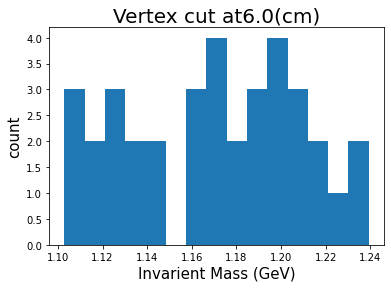

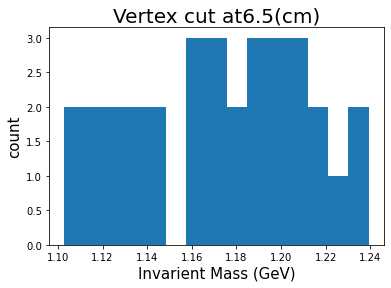

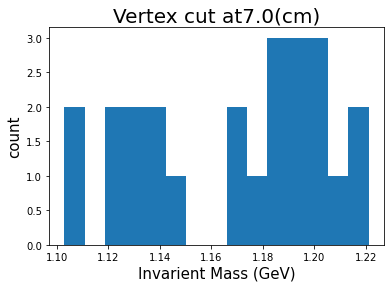

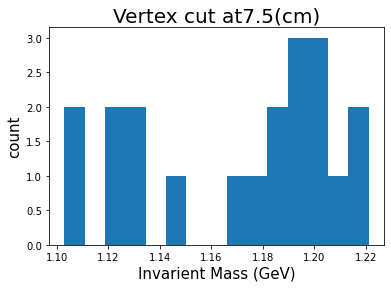

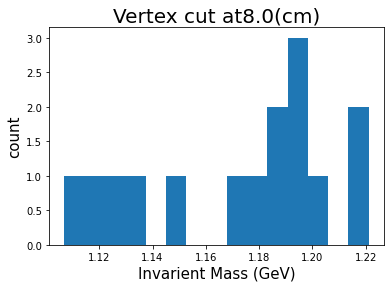

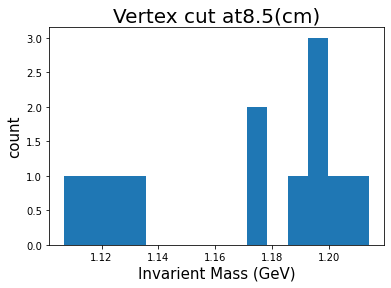

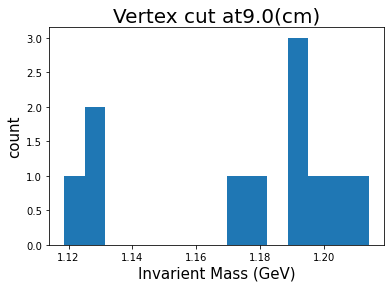

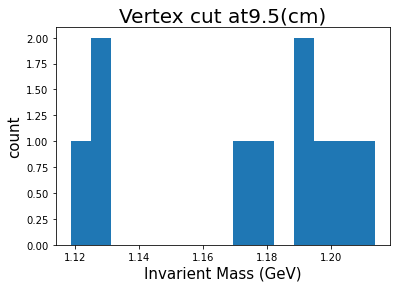

In [6]:
for j in range(0, 20):
    imass = []
    print('cut ',j/2)
    for i in range(len(pi_mas)):
        if pi_x[i]>j/2: 
            imass.append(pi_mas[i])
    plt.figure()
    plt.title('Vertex cut at'+str( j/2)+'(cm)', fontsize = 20)
    plt.xlabel('Invarient Mass (GeV)', fontsize = 15)
    plt.ylabel('count', fontsize = 15)
    plt.yticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.hist(imass, bins = 15)    